# Demo Layers

In [1]:
#@title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    %%capture
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob


# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

<Figure size 432x288 with 0 Axes>

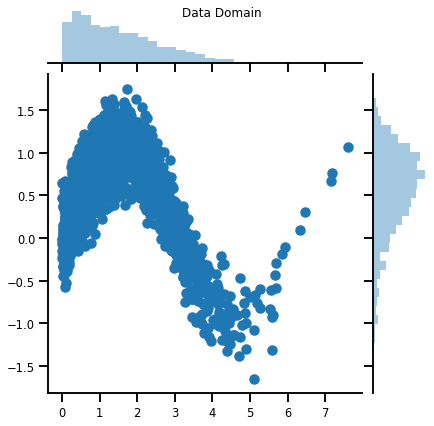

In [3]:
# %%wandb
# get data
n_samples = 2_000
n_features = 2
data = get_classic(n_samples)

# plot data
plt.figure()
sns.jointplot(data[:, 0], data[:, 1])
plt.suptitle('Data Domain')
plt.show()

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [4]:
X = np.array(data, dtype=np.float32)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Multiple Iterations

In [11]:
n_samples = 10_000
data = get_classic(n_samples)

X = np.array(data, dtype=np.float32)

##### Helper Function - Default Block Params

In [12]:
from rbig_jax.transforms.block import get_default_rbig_block

In [18]:
# histogram transformation parameters
support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(np.sqrt(X.shape[0]))
eps = 1e-5
n_layers = 30

# initialize with default block parameters
fit_transform_func, forward_f, grad_f, inverse_f = get_default_rbig_block(
    n_samples=n_samples,
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha,
)

# optional, compiles the function to make it faster
fit_transform_func_jitted = jax.jit(fit_transform_func)
forward_f_jitted = jax.jit(forward_f)
grad_f_jitted = jax.jit(grad_f)
inverse_f_jitted = jax.jit(inverse_f)

In [19]:
%%time


params = []
losses = []
ilayer = 0
X_g = X

while ilayer < n_layers:
    
    
    # compute 
    X_g, layer_params = fit_transform_func_jitted(X_g)
        
    # increment
    ilayer += 1
    
    params.append(layer_params)    

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 2.68 s, sys: 18 ms, total: 2.7 s
Wall time: 2.68 s


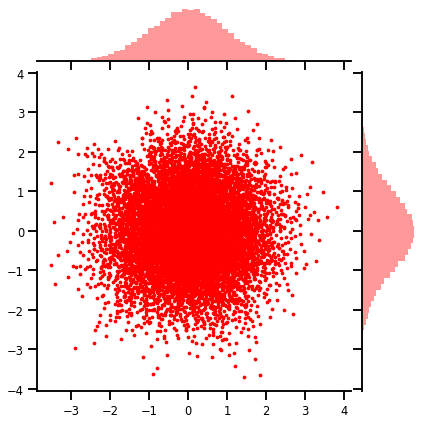

In [20]:
sns.jointplot(X_g[:, 0], X_g[:, 1], s=5, color='red')

### Forward Transform

In [24]:
from celluloid import Camera

CPU times: user 2.51 s, sys: 163 ms, total: 2.67 s
Wall time: 2.23 s


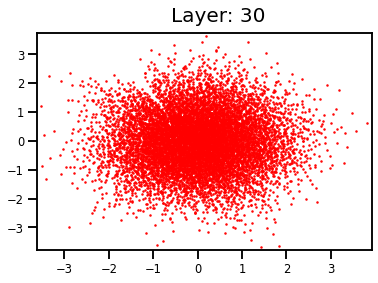

In [45]:
%%time

# initialize figure
fig, ax = plt.subplots()
camera = Camera(fig)

X_g_ = X

# ax.scatter(X_g_[:, 0], X_g_[:, 1], s=1, color="Red")
# ax.set_xlim([X_g_[:,0].min()-.1, X_g_[:,0].max()+.1])
# ax.set_ylim([X_g_[:,1].min()-.1, X_g_[:,1].max()+.1])
# ax.text(0.4, 1.05, f"Layer: {0}", transform=ax.transAxes, fontsize=20)
# camera.snap()


for ilayer, iparam in enumerate(params):

    X_g_ = forward_f_jitted(iparam, X_g_)
    
    ax.scatter(X_g_[:, 0], X_g_[:, 1], s=1, color="Red")
    ax.set_xlim([X_g_[:,0].min()-.1, X_g_[:,0].max()+.1])
    ax.set_ylim([X_g_[:,1].min()-.1, X_g_[:,1].max()+.1])
    ax.text(0.4, 1.05, f"Layer: {int(ilayer+1)}", transform=ax.transAxes, fontsize=20)
    camera.snap()
    
animation = camera.animate(500)
# HTML(animation.to_html5_video())
animation.save('./layers.gif')

### Inverse Transform

In [37]:
%%time

X_approx = X_g
for iparam in reversed(params):

    X_approx = inverse_f_jitted(iparam, X_approx)
    


CPU times: user 407 ms, sys: 6.59 ms, total: 413 ms
Wall time: 391 ms


In [38]:
chex.assert_tree_all_close(X_approx, X, rtol=1e-1)

<Figure size 432x288 with 0 Axes>

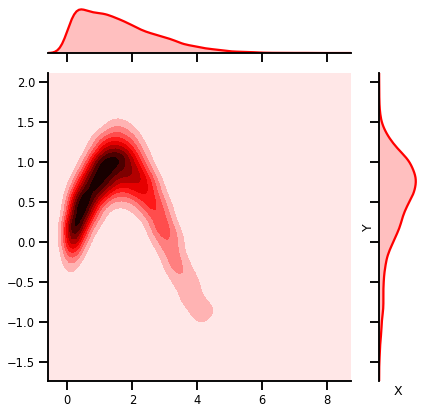

In [39]:
plot_joint(X_approx, kind="kde")

### Probabilities

In [27]:
ngrid = 1_000
buffer = 0.1
xline = np.linspace(data[:,0].min()-buffer, data[:,0].max()+buffer, ngrid)
yline = np.linspace(data[:,1].min()-buffer, data[:,1].max()+buffer, ngrid)
xgrid, ygrid = np.meshgrid(xline, yline)
xyinput = np.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)

In [36]:
%%time

X_g = xyinput
X_ldj = np.zeros_like(xyinput)
for iparam in params:

    X_g, iX_ldj = grad_f_jitted(iparam, X_g)
    X_ldj += iX_ldj
    


CPU times: user 10.5 s, sys: 405 ms, total: 10.9 s
Wall time: 1.39 s


In [38]:
latent_prob = jax.scipy.stats.norm.logpdf(X_g)

log_prob = (latent_prob + X_ldj).sum(-1)

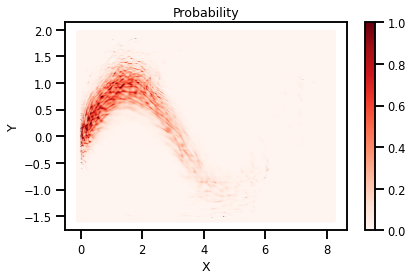

In [39]:
cmap = "Reds"
probs = np.exp(log_prob)
# probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(xyinput[:, 0], xyinput[:, 1], s=1, c=probs,  cmap=cmap, vmin=0.0, vmax=1.0)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()
plt.savefig("./probs.png")
plt.show()

### Log Likelihood

In [34]:
nll = -log_prob.mean()
print(nll)

inf
